# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [1]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [78]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [79]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [80]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='1d'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

In [ ]:
# Save data to CSV
for ticker, data in database.items():
    filename = f"{ticker}_data.csv"
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Functions

Model functions

In [81]:
def model_1(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [82]:
def model_2(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=True),
        SimpleRNN(32, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

Other functions

In [83]:
def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols):
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2 = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.0008 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None

            print('{:<1} '.format(count), 
                  '{:<8} -'.format(ticker), 
                  'LastPrice: {:<11}'.format(round(float(last_price), 4)), 
                  '/ Pred1: {:<11}'.format(round(float(pred1), 4)), 
                  '/ Pred2: {:<11}'.format(round(float(pred2), 4)), 
                  '/ TruePrice1: {:<11}'.format(round(float(true_price1), 4)), 
                  '/ TruePrice2: {:<11}'.format(round(float(true_price2), 4)), 
                  '|| ActStatus: {:<1}'.format(act_status), 
                  '/ MyActStatus: {:<1}'.format(my_act_status), 
                  '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                  '/ MyGamble: {:<11}'.format(round(float(my_gamble), 2)), 
                  '/ GambleProft: {:<6}'.format(round(float(gamble_proft), 4) if gamble_proft is not None else ''), 
                  '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        print('\nLook_back:', lb)
        index = my_confusion_matrix(true_status_list, pred_status_list)
        for i in index:
            print(symbols[i])

In [84]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [85]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        return pred1 + (pred1 * margin)
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        return pred1

    else:
        return pred1 - (pred1 * margin)

In [86]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate

Loss: 11742183.0
1  BTCBRL   LastPrice: 333253.0  / Pred1: 338845.03 / Pred2: 347028.0  / TruePrice1: 343050.0  / TruePrice2: 344619.0  || ActStatus: 1 / MyActStatus: 1 / MyGamble: 338845.03 / SoldStatus: 1 / GambleProft: 1.0168 || CorrectModel: 1
Loss: 7.768765499349684e-05
2  USDTBRL  LastPrice: 4.99      / Pred1: 5.03      / Pred2: 5.05      / TruePrice1: 5.04      / TruePrice2: 5.04      || ActStatus: 1 / MyActStatus: 1 / MyGamble: 5.02      / SoldStatus: 1 / GambleProft: 1.0075 || CorrectModel: 1
Loss: 37983.48046875
3  ETHBRL   LastPrice: 19296.22  / Pred1: 19286.11  / Pred2: 19732.43  / TruePrice1: 19556.48  / TruePrice2: 19678.89  || ActStatus: 1 / MyActStatus: 0 / MyGamble: 19296.22  / SoldStatus:   / GambleProft:        || CorrectModel: 1
Loss: 3900.65576171875
4  BNBBRL   LastPrice: 2368.0    / Pred1: 2434.05   / Pred2: 2550.05   / TruePrice1: 2449.0    / TruePrice2: 2463.0    || ActStatus: 1 / MyActStatus: 1 / MyGamble: 2415.36   / SoldStatus: 1 / GambleProft: 1.02   || Cor

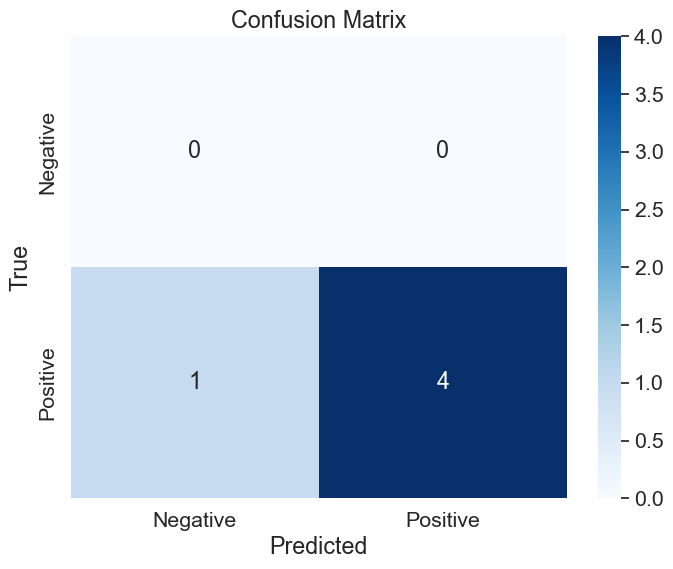

In [64]:
pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols[:5])

Loss: 125515648.0
1  BTCBRL   LastPrice: 333253.0  / Pred1: 328594.91 / Pred2: 338131.94 / TruePrice1: 343050.0  / TruePrice2: 344619.0  || ActStatus: 0 / MyActStatus: 0 / MyGamble: 333253.0  / SoldStatus:   / GambleProft:      || CorrectModel: 0
Loss: 0.0005056089139543474
2  USDTBRL  LastPrice: 4.99      / Pred1: 5.04      / Pred2: 5.07      / TruePrice1: 5.04      / TruePrice2: 5.04      || ActStatus: 1 / MyActStatus: 1 / MyGamble: 5.03      / SoldStatus: 1 / GambleProft: 1.01 || CorrectModel: 1
Loss: 61527.88671875
3  ETHBRL   LastPrice: 19296.22  / Pred1: 19211.02  / Pred2: 19617.98  / TruePrice1: 19556.48  / TruePrice2: 19678.89  || ActStatus: 0 / MyActStatus: 0 / MyGamble: 19296.22  / SoldStatus:   / GambleProft:      || CorrectModel: 0
Loss: 2023.6273193359375
4  BNBBRL   LastPrice: 2368.0    / Pred1: 2386.13   / Pred2: 2472.72   / TruePrice1: 2449.0    / TruePrice2: 2463.0    || ActStatus: 1 / MyActStatus: 1 / MyGamble: 2386.13   / SoldStatus: 1 / GambleProft: 1.01 || CorrectM

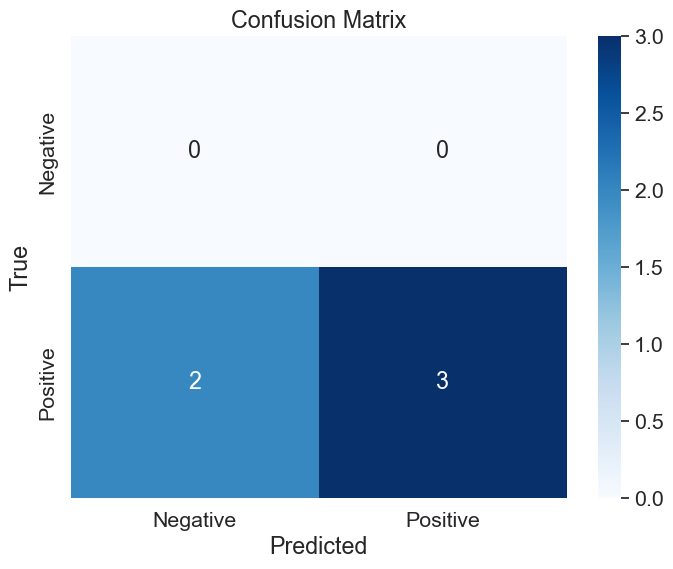

In [61]:
pred_eval(model_1, epochs = 250, lb_list = [11], ticker_list = symbols[:5])

Loss: 28496562.0
1  BTCBRL   LastPrice: 333253.0    / Pred1: 350447.8438 / Pred2: 346124.1562 / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 350097.4    / GambleProft:        || CorrectModel: 0
Loss: 0.0006456655682995915
2  USDTBRL  LastPrice: 4.986       / Pred1: 5.0003      / Pred2: 5.0461      / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 5.0         / GambleProft: 1.0019 || CorrectModel: 1
Loss: 21262.794921875
3  ETHBRL   LastPrice: 19296.22    / Pred1: 19350.707   / Pred2: 19665.3652  / TruePrice1: 19556.48    / TruePrice2: 19678.89    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 19350.71    / GambleProft: 1.0028 || CorrectModel: 1
Loss: 7453.16943359375
4  BNBBRL   LastPrice: 2368.0      / Pred1: 2348.9707   / Pred2: 2392.9968   / TruePrice1: 2449.0      / TruePrice2: 2463.0      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / M

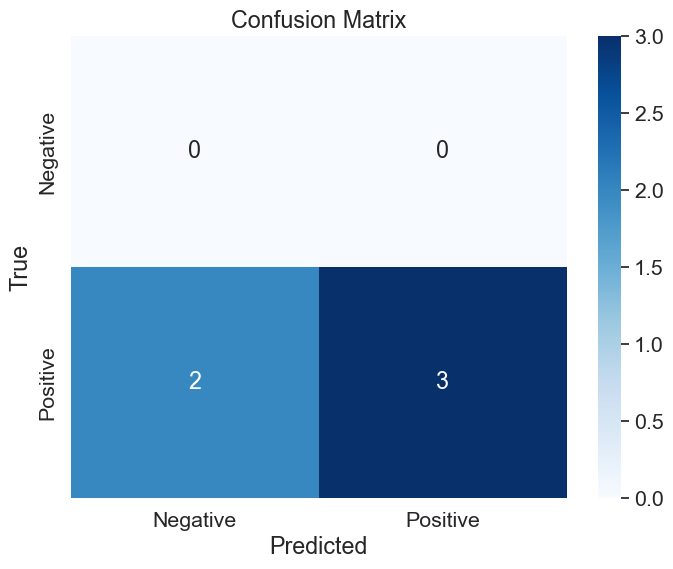

In [72]:
pred_eval(model_1, epochs = 1500, lb_list = [11], ticker_list = symbols[:5])

Loss: 21983412.0
1  BTCBRL   LastPrice: 333253.0    / Pred1: 343099.625  / Pred2: 337988.4375 / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 342756.53   / GambleProft:        || CorrectModel: 0
Loss: 0.0011715734144672751
2  USDTBRL  LastPrice: 4.986       / Pred1: 4.988       / Pred2: 5.036       / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 4.99        / GambleProft:        || CorrectModel: 1
Loss: 42941.26953125
3  ETHBRL   LastPrice: 19296.22    / Pred1: 19312.5996  / Pred2: 19516.3926  / TruePrice1: 19556.48    / TruePrice2: 19678.89    || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19296.22    / GambleProft:        || CorrectModel: 1
Loss: 580.26953125
4  BNBBRL   LastPrice: 2368.0      / Pred1: 2428.0713   / Pred2: 2436.1199   / TruePrice1: 2449.0      / TruePrice2: 2463.0      || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamb

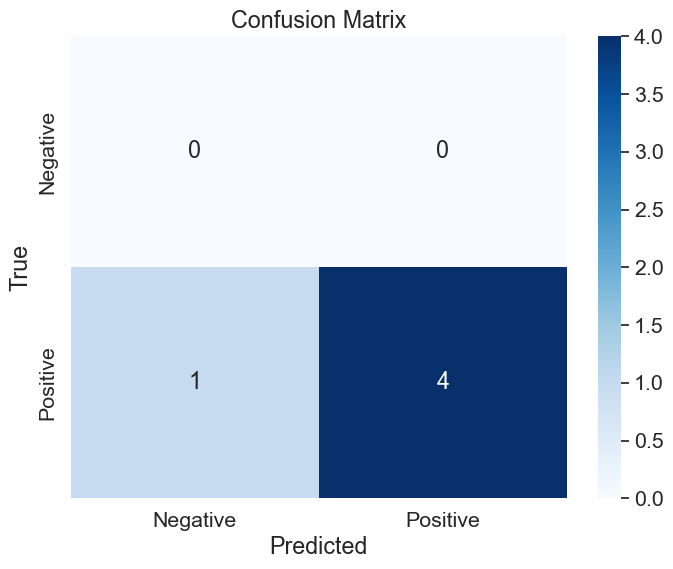

In [73]:
pred_eval(model_1, epochs = 2000, lb_list = [11], ticker_list = symbols[:5])

In [77]:
pred_eval(model_1, epochs = 2100, lb_list = [11], ticker_list = symbols[:3])

Loss: 1747208.0
1  BTCBRL   LastPrice: 333253.0    / Pred1: 344416.6875 / Pred2: 345894.375  / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 0 / MyGamble: 344072.27   / GambleProft: 1.0325 || CorrectModel: 1
Loss: 0.0011491485638543963
2  USDTBRL  LastPrice: 4.986       / Pred1: 4.9885      / Pred2: 5.0352      / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 4.99        / GambleProft:        || CorrectModel: 1
Loss: 10764.798828125
3  ETHBRL   LastPrice: 19296.22    / Pred1: 19449.0391  / Pred2: 19578.9609  / TruePrice1: 19556.48    / TruePrice2: 19678.89    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 19429.59    / GambleProft: 1.0069 || CorrectModel: 1

Pred proft %: 1.0320986359519775
Gamble proft %: 1.0310665442350089
True proft %: 1.0285269891234825

Look_back: 11


ValueError: cannot reshape array of size 1 into shape (2,2)

In [ ]:
pred_eval(model_1, epochs = 2200, lb_list = [11], ticker_list = symbols[:3])

In [75]:
pred_eval(model_1, epochs = 2300, lb_list = [11], ticker_list = symbols[:3])

Loss: 4895249.5
1  BTCBRL   LastPrice: 333253.0    / Pred1: 343747.75   / Pred2: 347669.1875 / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 339918.06   / GambleProft: 1.02   || CorrectModel: 1
Loss: 0.001078667351976037
2  USDTBRL  LastPrice: 4.986       / Pred1: 4.9897      / Pred2: 5.0386      / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 4.99        / GambleProft:        || CorrectModel: 1


KeyboardInterrupt: 

Loss: 10783881.0
1  BTCBRL   LastPrice: 333253.0    / Pred1: 347375.3438 / Pred2: 342928.0938 / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 347027.97   / GambleProft:        || CorrectModel: 0
Loss: 0.0028649966698139906
2  USDTBRL  LastPrice: 4.986       / Pred1: 4.9661      / Pred2: 5.0131      / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 4.99        / GambleProft:        || CorrectModel: 0
Loss: 9032.740234375
3  ETHBRL   LastPrice: 19296.22    / Pred1: 19428.793   / Pred2: 19636.9277  / TruePrice1: 19556.48    / TruePrice2: 19678.89    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 19428.79    / GambleProft: 1.0069 || CorrectModel: 1

Pred proft %: 1.0068704113422213
Gamble proft %: 1.0068704113422213
True proft %: 1.0134876157091905

Look_back: 11
CM accuracy: 0.3333333333333333


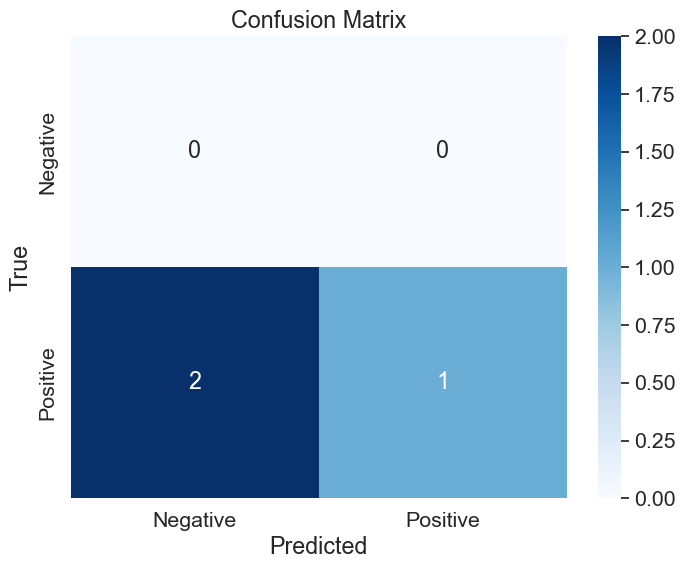

In [76]:
pred_eval(model_1, epochs = 2390, lb_list = [11], ticker_list = symbols[:3])

Loss: 3913705.25
1  BTCBRL   LastPrice: 333253.0  / Pred1: 341303.56 / Pred2: 342433.25 / TruePrice1: 343050.0  / TruePrice2: 344619.0  || ActStatus: 1 / MyActStatus: 1 / MyGamble: 340962.26 / SoldStatus: 1 / GambleProft: 1.0231 || CorrectModel: 1
Loss: 0.002331499010324478
2  USDTBRL  LastPrice: 4.99      / Pred1: 4.97      / Pred2: 5.02      / TruePrice1: 5.04      / TruePrice2: 5.04      || ActStatus: 0 / MyActStatus: 0 / MyGamble: 4.99      / SoldStatus:   / GambleProft:        || CorrectModel: 0
Loss: 6818.5390625
3  ETHBRL   LastPrice: 19296.22  / Pred1: 19671.6   / Pred2: 19698.48  / TruePrice1: 19556.48  / TruePrice2: 19678.89  || ActStatus: 1 / MyActStatus: 1 / MyGamble: 19651.93  / SoldStatus: 0 / GambleProft: 1.0184 || CorrectModel: 1
Loss: 324.0367736816406
4  BNBBRL   LastPrice: 2368.0    / Pred1: 2424.5    / Pred2: 2469.91   / TruePrice1: 2449.0    / TruePrice2: 2463.0    || ActStatus: 1 / MyActStatus: 1 / MyGamble: 2415.36   / SoldStatus: 1 / GambleProft: 1.02   || Corre

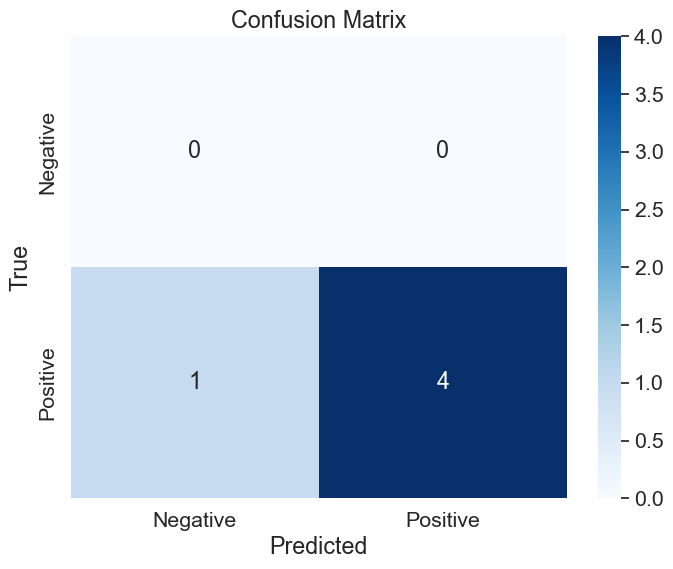

In [65]:
pred_eval(model_1, epochs = 2500, lb_list = [11], ticker_list = symbols[:5])

In [74]:
pred_eval(model_1, epochs = 3000, lb_list = [11], ticker_list = symbols[:5])

Loss: 5525342.0
1  BTCBRL   LastPrice: 333253.0    / Pred1: 345315.2812 / Pred2: 342186.0625 / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 344969.97   / GambleProft:        || CorrectModel: 0
Loss: 0.0022574830800294876
2  USDTBRL  LastPrice: 4.986       / Pred1: 4.9721      / Pred2: 5.0211      / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 4.99        / GambleProft:        || CorrectModel: 0
Loss: 24362.1875
3  ETHBRL   LastPrice: 19296.22    / Pred1: 19526.082   / Pred2: 19460.2598  / TruePrice1: 19556.48    / TruePrice2: 19678.89    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19506.56    / GambleProft:        || CorrectModel: 0


KeyboardInterrupt: 

Loss: 7033808.0
1  BTCBRL   LastPrice: 333253.0    / Pred1: 340809.3125 / Pred2: 341611.1875 / TruePrice1: 343050.0    / TruePrice2: 344619.0    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 340468.5    / GambleProft: 1.0217 || CorrectModel: 1
Loss: 0.0021364460699260235
2  USDTBRL  LastPrice: 4.986       / Pred1: 4.9739      / Pred2: 5.0215      / TruePrice1: 5.036       / TruePrice2: 5.042       || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 4.99        / GambleProft:        || CorrectModel: 1
Loss: 86368.59375
3  ETHBRL   LastPrice: 19296.22    / Pred1: 19170.3008  / Pred2: 19525.2617  / TruePrice1: 19556.48    / TruePrice2: 19678.89    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19296.22    / GambleProft:        || CorrectModel: 0

Pred proft %: 1.0226740265662373
Gamble proft %: 1.0216514036890927
True proft %: 1.0293977951364084

Look_back: 11
CM accuracy: 0.6666666666666666


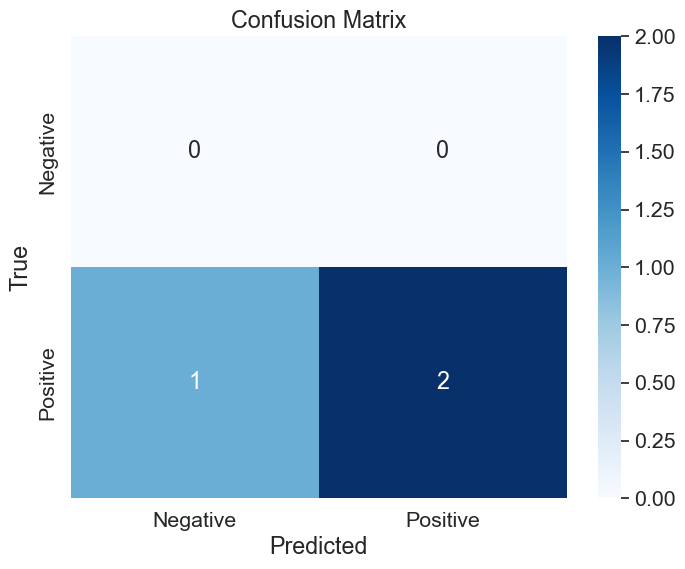

In [68]:
pred_eval(model_1, epochs = 3500, lb_list = [11], ticker_list = symbols[:5])

Loss: 9981394.0
1  BTCBRL   - LastPrice: 343050.0    / Pred1: 344608.7188 / Pred2: 343346.0312 / TruePrice1: 344444.0    / TruePrice2: 347811.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 344264.11   / GambleProft:        || CorrectModel: 0
Loss: 0.0001600545074325055
2  USDTBRL  - LastPrice: 5.036       / Pred1: 5.0358      / Pred2: 5.0438      / TruePrice1: 5.042       / TruePrice2: 5.027       || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:        || CorrectModel: 1
Loss: 2170.645751953125
3  ETHBRL   - LastPrice: 19556.48    / Pred1: 19741.3105  / Pred2: 19723.8398  / TruePrice1: 19691.93    / TruePrice2: 19767.46    || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 19721.57    / GambleProft: 1.0084 || CorrectModel: 1

Pred proft %: 1.0094486706480026
Gamble proft %: 1.0084394909028587
True proft %: 1.0069246166810386

Look_back: 11
CM accuracy: 0.6666666666666666


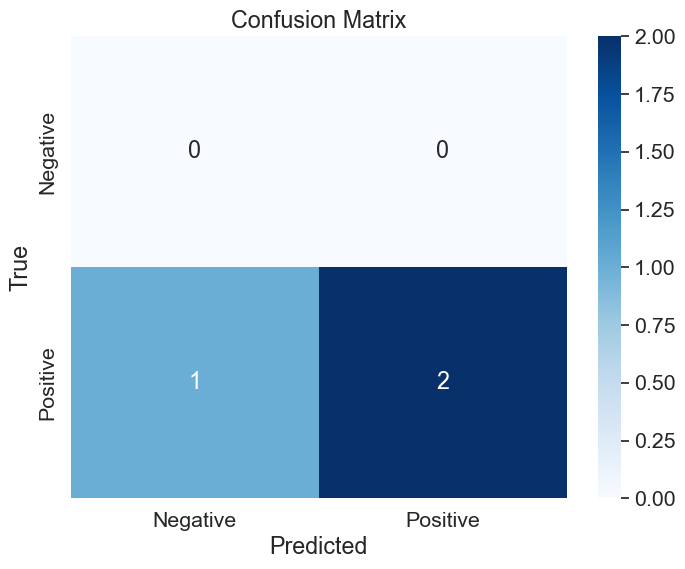

In [87]:
pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

Loss: 19103962.0
1  BTCBRL   - LastPrice: 343050.0    / Pred1: 350591.8125 / Pred2: 348453.125  / TruePrice1: 344444.0    / TruePrice2: 347811.0    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 350241.22   / GambleProft:        || CorrectModel: 0
Loss: 0.00045922043500468135
2  USDTBRL  - LastPrice: 5.036       / Pred1: 5.0138      / Pred2: 5.016       / TruePrice1: 5.042       / TruePrice2: 5.027       || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:        || CorrectModel: 0
Loss: 192507.25
3  ETHBRL   - LastPrice: 19556.48    / Pred1: 19261.7207  / Pred2: 19320.3223  / TruePrice1: 19691.93    / TruePrice2: 19767.46    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48    / GambleProft:        || CorrectModel: 0

All False

Look_back: 11
CM accuracy: 0.0


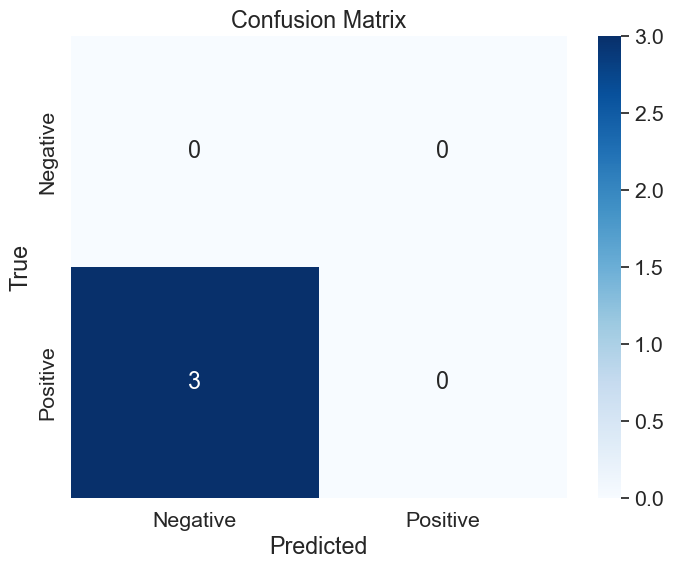

In [88]:
pred_eval(model_1, epochs = 10000, lb_list = [11], ticker_list = symbols[:3])

Loss: 3372910.0
1  BTCBRL   - LastPrice: 343050.0    / Pred1: 342277.625  / Pred2: 346378.3438 / TruePrice1: 344444.0    / TruePrice2: 347811.0    || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0    / GambleProft:        || CorrectModel: 1
Loss: 0.00017374736489728093
2  USDTBRL  - LastPrice: 5.036       / Pred1: 5.0358      / Pred2: 5.0446      / TruePrice1: 5.042       / TruePrice2: 5.027       || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.04        / GambleProft:        || CorrectModel: 1
Loss: 176785.171875
3  ETHBRL   - LastPrice: 19556.48    / Pred1: 19372.5254  / Pred2: 19265.9121  / TruePrice1: 19691.93    / TruePrice2: 19767.46    || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48    / GambleProft:        || CorrectModel: 0

Pred proft %: 0.9977485385464323
Gamble proft %: 1.0
True proft %: 1.0040635054254092

Look_back: 11
CM accuracy: 0.6666666666666666


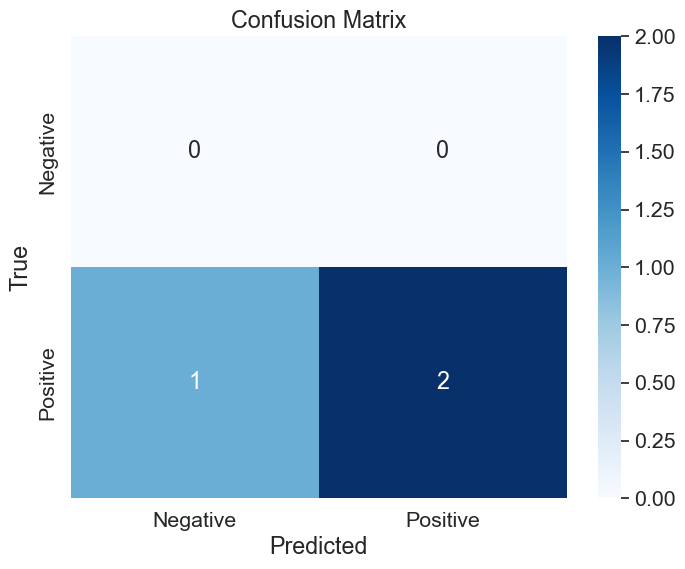

In [89]:
pred_eval(model_1, epochs = 20000, lb_list = [11], ticker_list = symbols[:3])

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
